<a href="https://colab.research.google.com/github/robinjmf/Audio_Analysis/blob/main/Music_Genre_Classification_Recom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# # Install kaggle and kagglehub
# !pip install kaggle kagglehub


In [2]:
import kagglehub
import shutil
import os


# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)


# Define the target path
target_path = '/kaggle/input/gtzan-dataset-music-genre-classification'
os.makedirs(target_path, exist_ok=True)

# Move files from the download location to the target path
shutil.move(path, target_path)

print("Dataset successfully moved to:", target_path)

# print("Path to dataset files:", download_path)


100%|██████████| 1.21G/1.21G [00:22<00:00, 57.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1
Dataset successfully moved to: /kaggle/input/gtzan-dataset-music-genre-classification


# GTZAN - Deep Learning

`Music Genre Classification Problem`. Experts have been trying for a long time to understand sound & what differentiates one from another. How to visualize sound. What makes one tone different from another.

We are going to analyze the features extracted from the GTZAN dataset and build different type of ensemble models to see how better we can differentiate one genre from another.

Our Datasets contains 10 genres:-
- Blues
- Classical
- Country
- Disco
- Hiphop
- Jazz
- Metal
- Pop
- Reggae
- Rock


# Reading & Understanding Data
## Importing Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

### Loading Dataset

In [5]:
df = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/1/Data/features_3_sec.csv')
df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

### About the dataset

In [6]:
print("Dataset has",df.shape)
print("Count of Positive and Negative samples")
df.label.value_counts().reset_index()

Dataset has (9990, 60)
Count of Positive and Negative samples


label  count
0      blues   1000
1       jazz   1000
2      metal   1000
3        pop   1000
4     reggae   1000
5      disco    999
6  classical    998
7     hiphop    998
8       rock    998
9    country    997

# Data Visualization

In [27]:
audio_fp = '/kaggle/input/gtzan-dataset-music-genre-classification/1/Data/genres_original/blues/blues.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

In [28]:
# play sample file
IPython.display.Audio(audio_data, rate=sr)

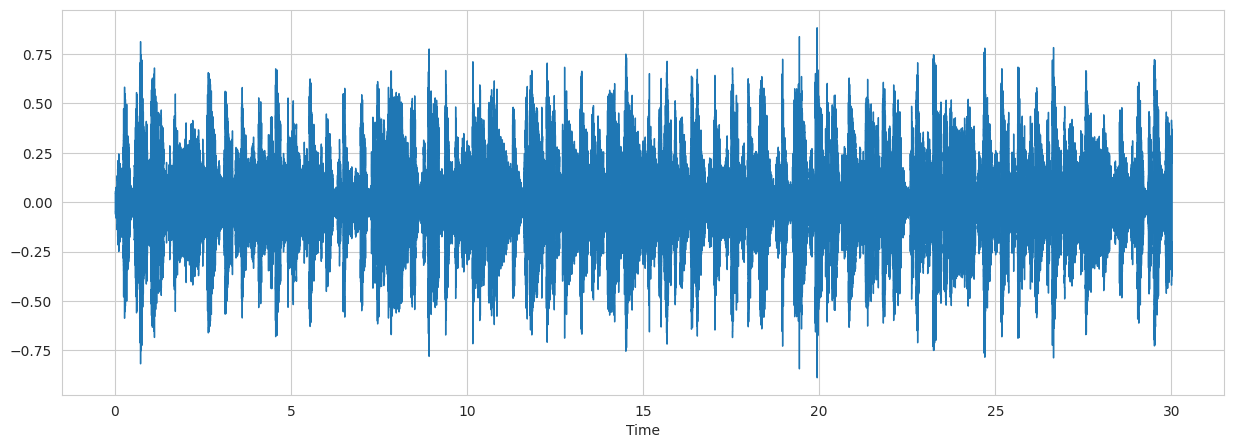

In [29]:
# plot sample file
plt.figure(figsize=(15,5))
lplt.waveshow(audio_data)
plt.show()

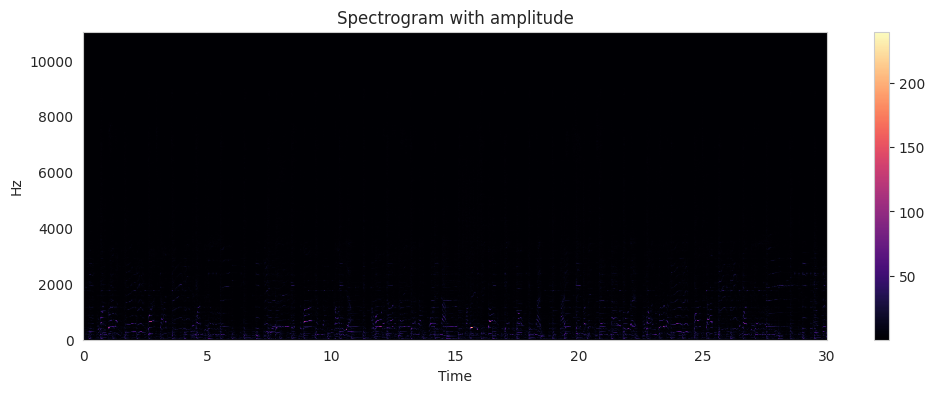

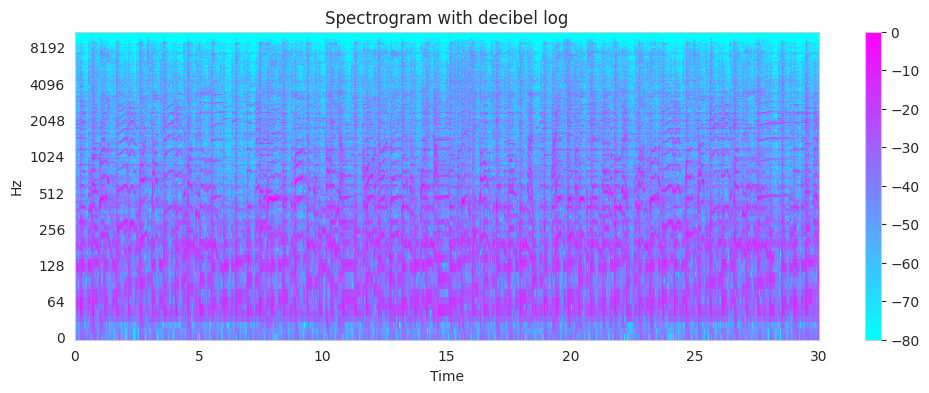

In [30]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

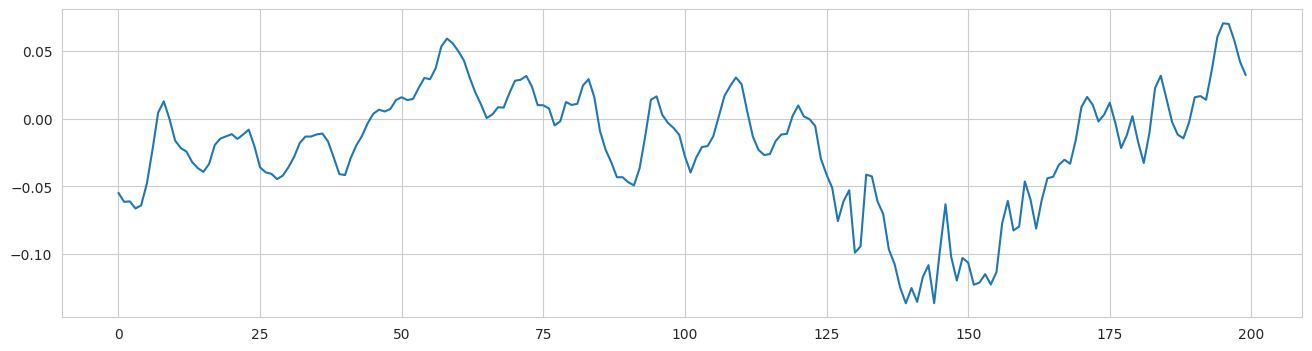

In [31]:
# plot zoomed audio wave
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(audio_data[start:end])
plt.show()

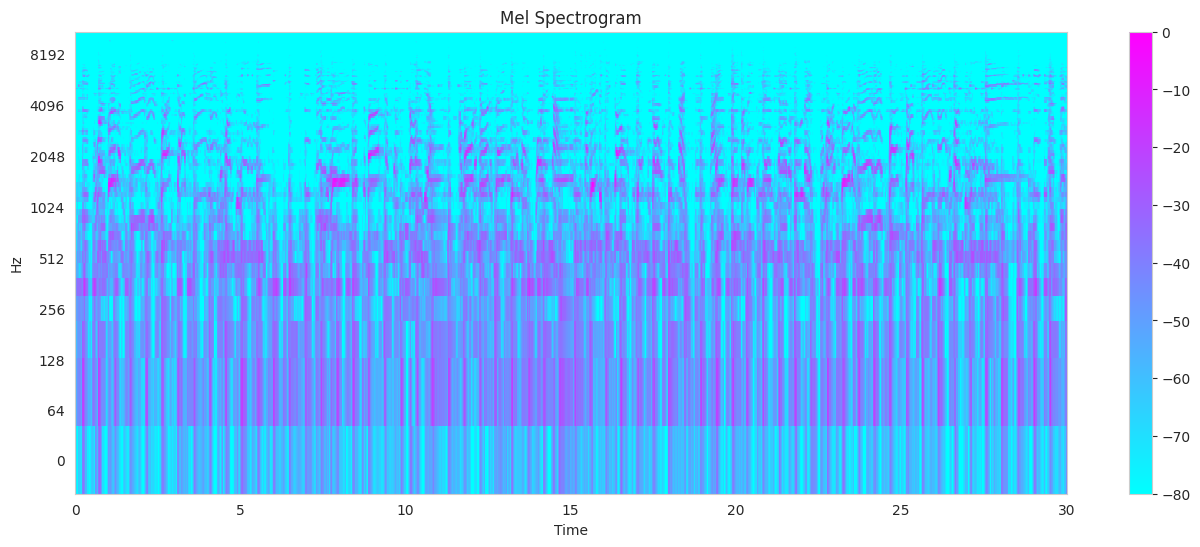

In [32]:
mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()

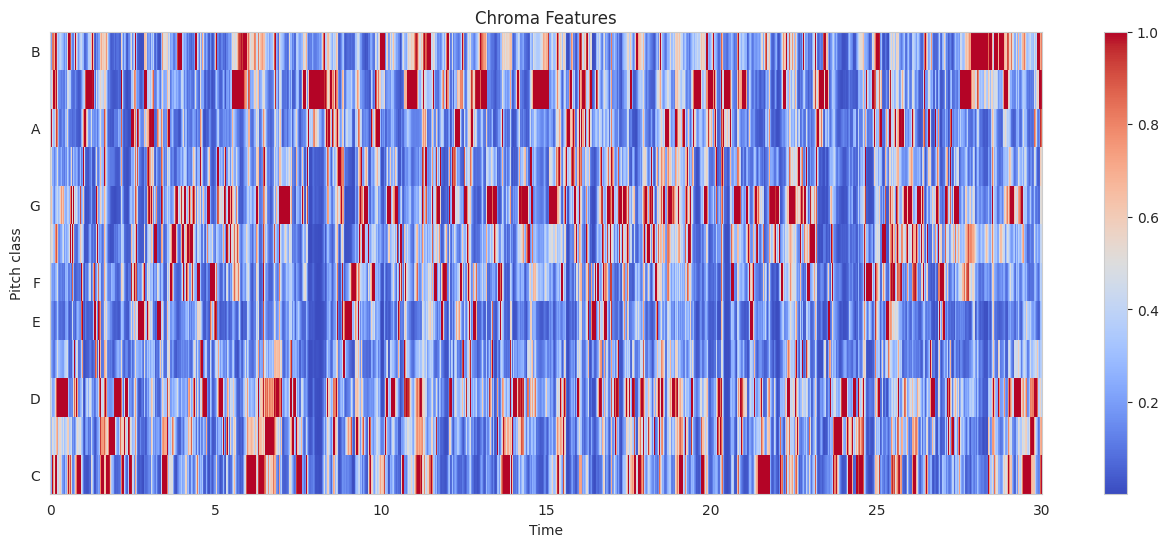

In [33]:
chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

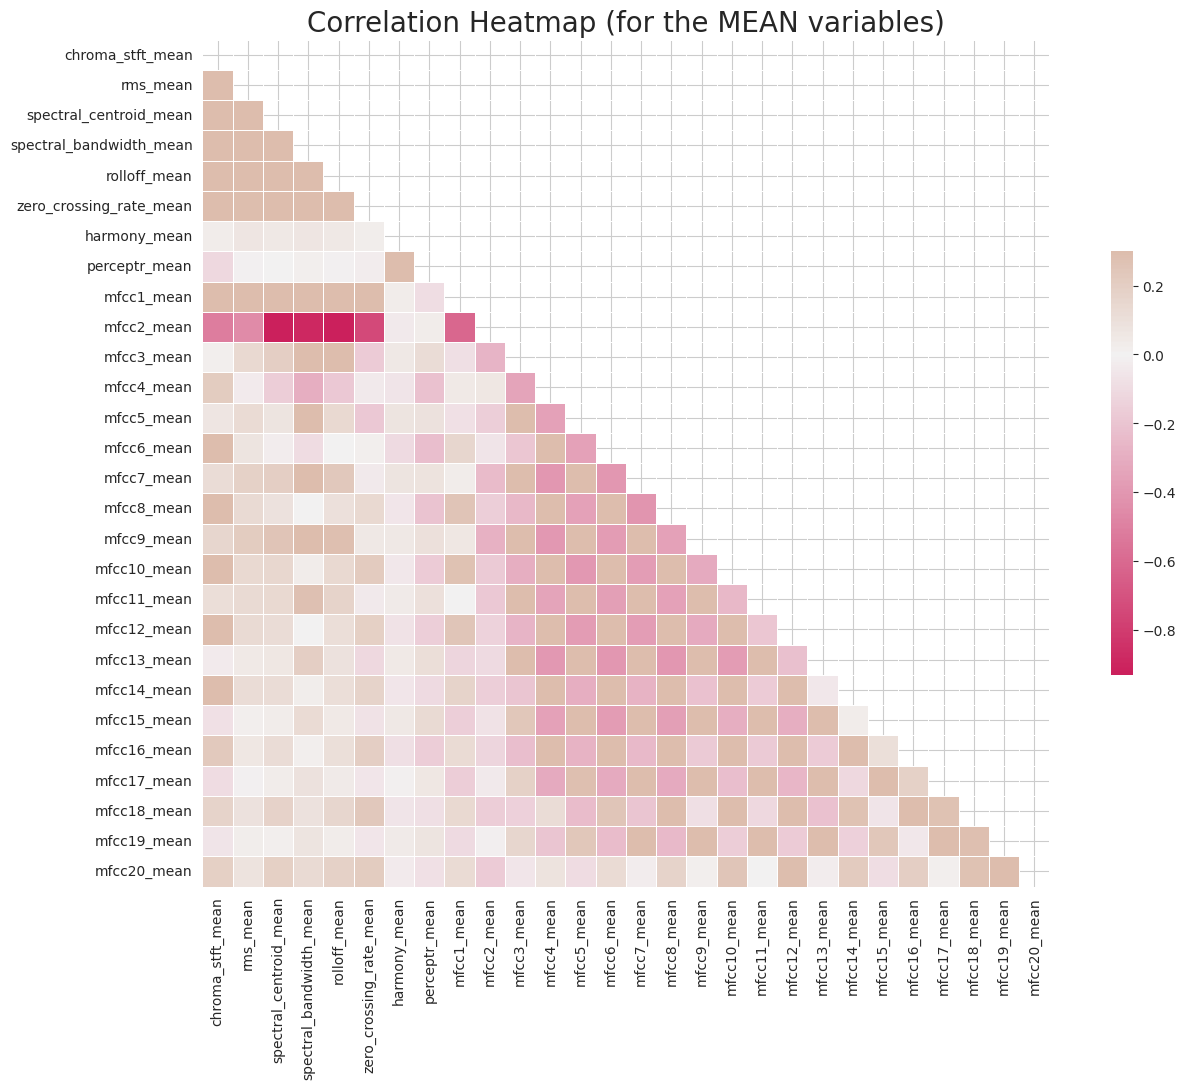

In [34]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr_Heatmap.png")

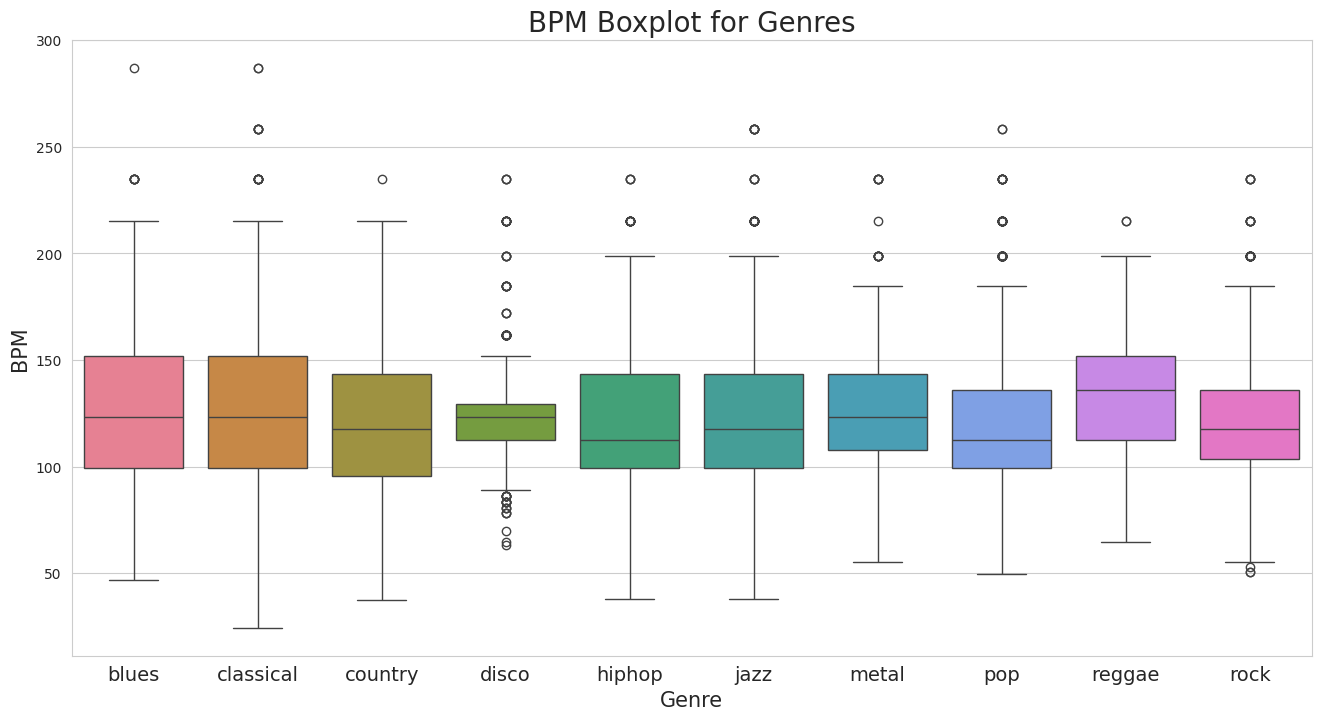

In [35]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

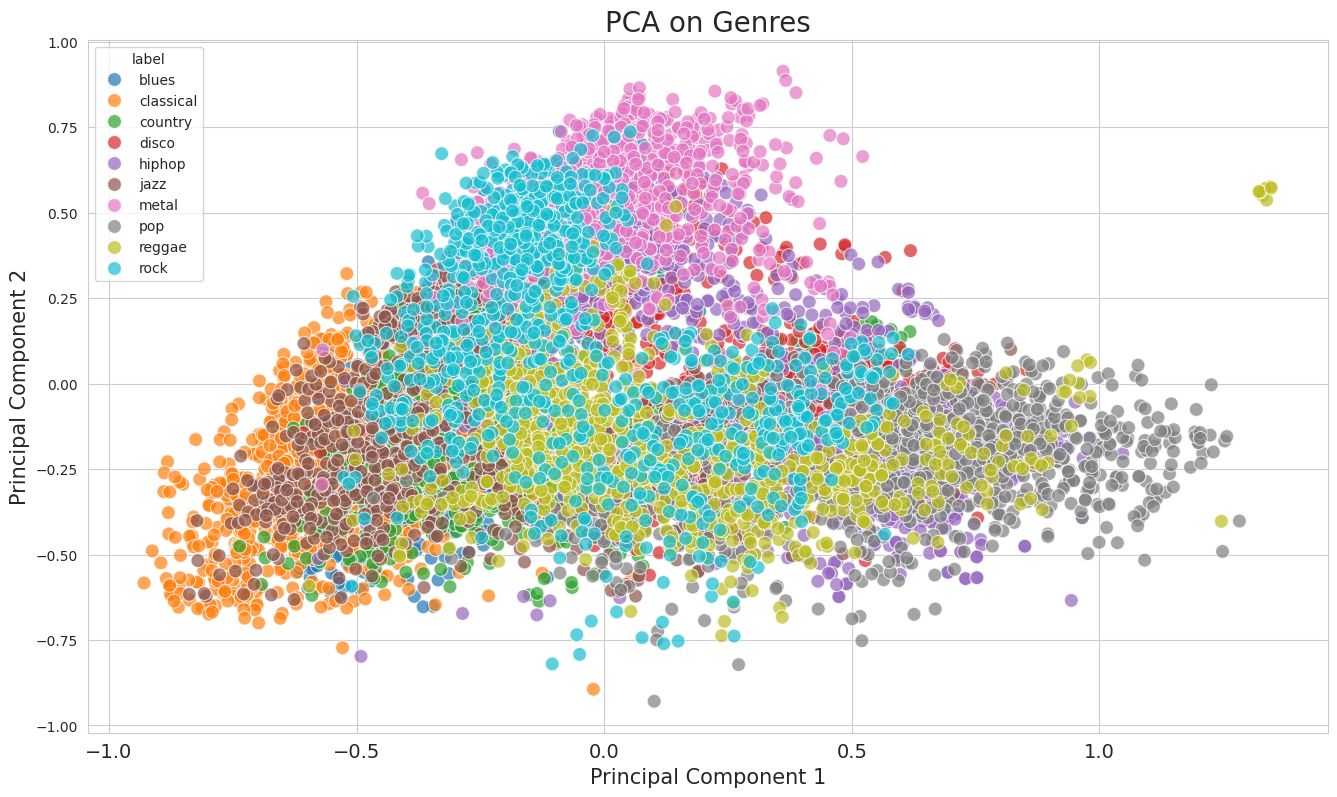

In [36]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Top 2 pca components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA_Scattert.png")

In [83]:
# Importing a random file
y, sr = librosa.load(f'{target_path}/1/Data/genres_original/reggae/reggae.00036.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Verify length of the audio
print('Check Len of Audio:', np.shape(y)[0]/sr)

y: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


In [84]:
# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
audio_file, _ = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

Audio File shape: (661794,)


### 2D Representation: Sound Waves

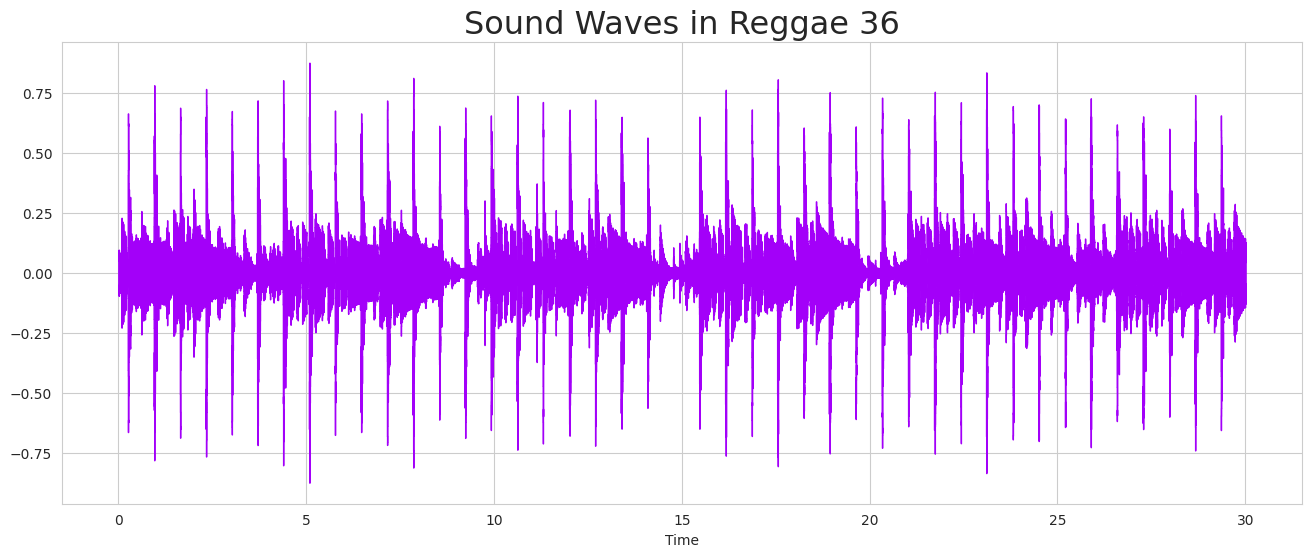

In [85]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio_file, sr = sr, color = "#A300F9");
plt.title("Sound Waves in Reggae 36", fontsize = 23);

# Feature Extraction

### Fourier Transform

* Function that gets a signal in the time domain as input, and outputs its decomposition into frequencies
* Transform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is approx. the log scale of amplitudes.

In [ ]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))

print('Shape of D object:', np.shape(D))

Shape of D object: (1025, 1293)


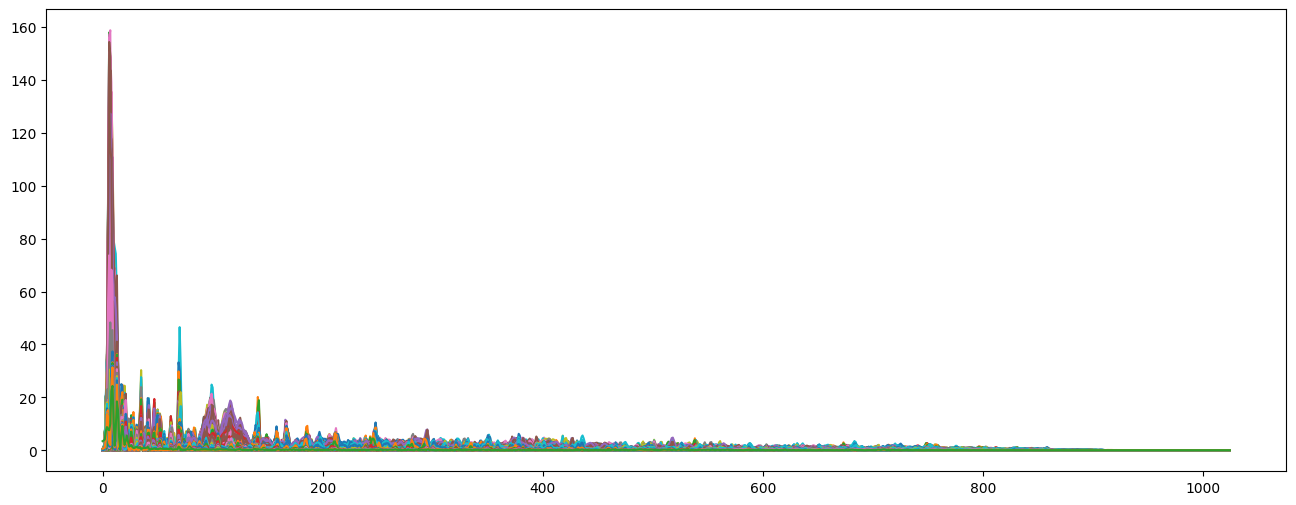

In [ ]:
plt.figure(figsize = (16, 6))
plt.plot(D);

### The Spectrogram

* What is a spectrogram? A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. When applied to an audio signal, spectrograms are sometimes called sonographs, voiceprints, or voicegrams ([wiki](https://en.wikipedia.org/wiki/Spectrogram)).
* Here we convert the frequency axis to a logarithmic one.

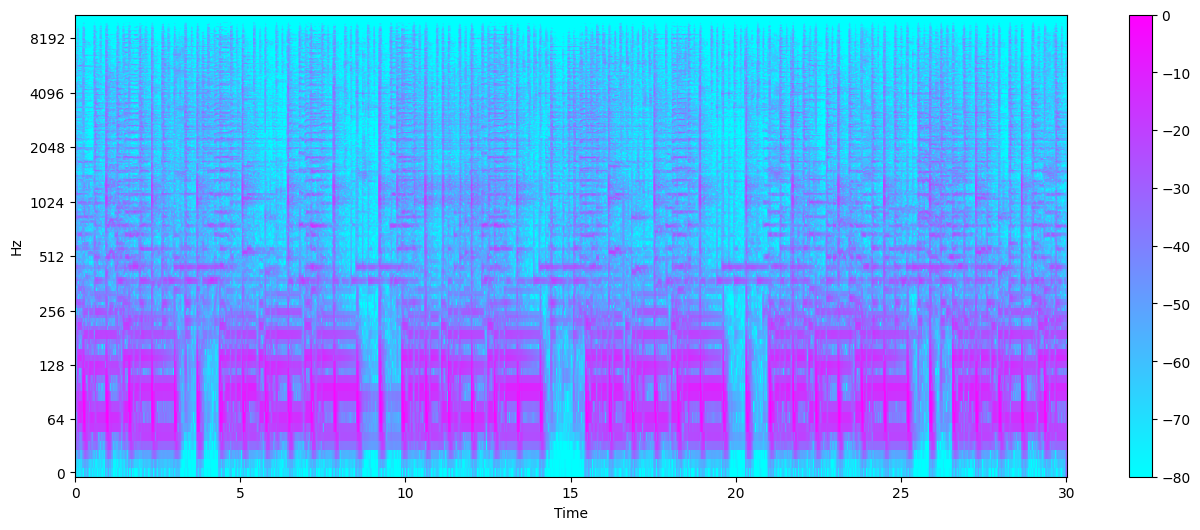

In [ ]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the Spectogram
plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool')
plt.colorbar();

### Mel Spectrogram

* The Mel Scale, mathematically speaking, is the result of some non-linear transformation of the frequency scale. The Mel Spectrogram is a normal Spectrogram, but with a Mel Scale on the y axis.

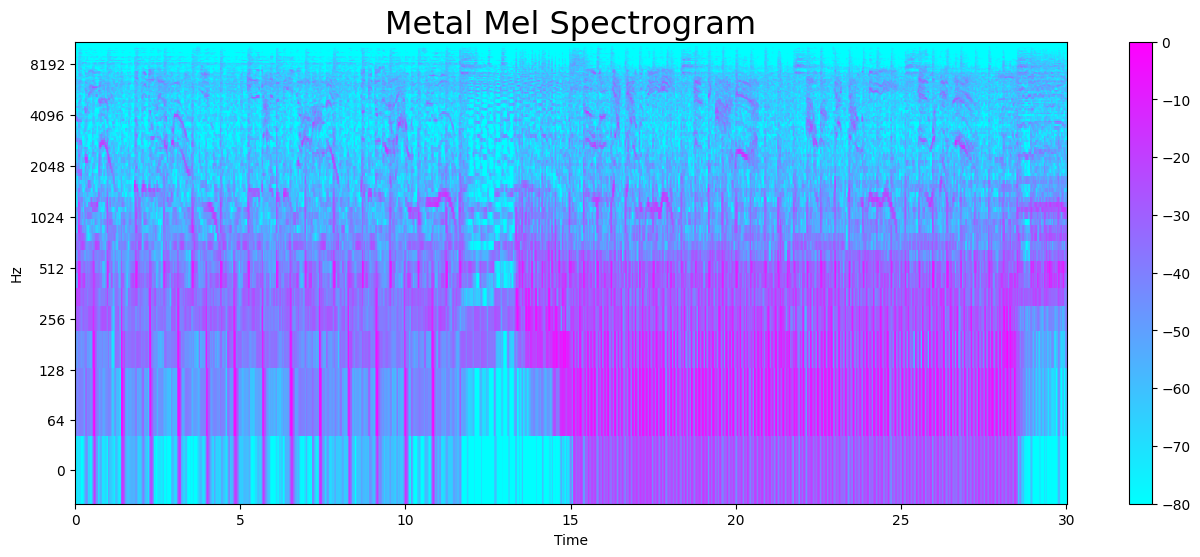

In [ ]:
y, sr = librosa.load(f'{general_path}/genres_original/metal/metal.00036.wav')
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool');
plt.colorbar();
plt.title("Metal Mel Spectrogram", fontsize = 23);

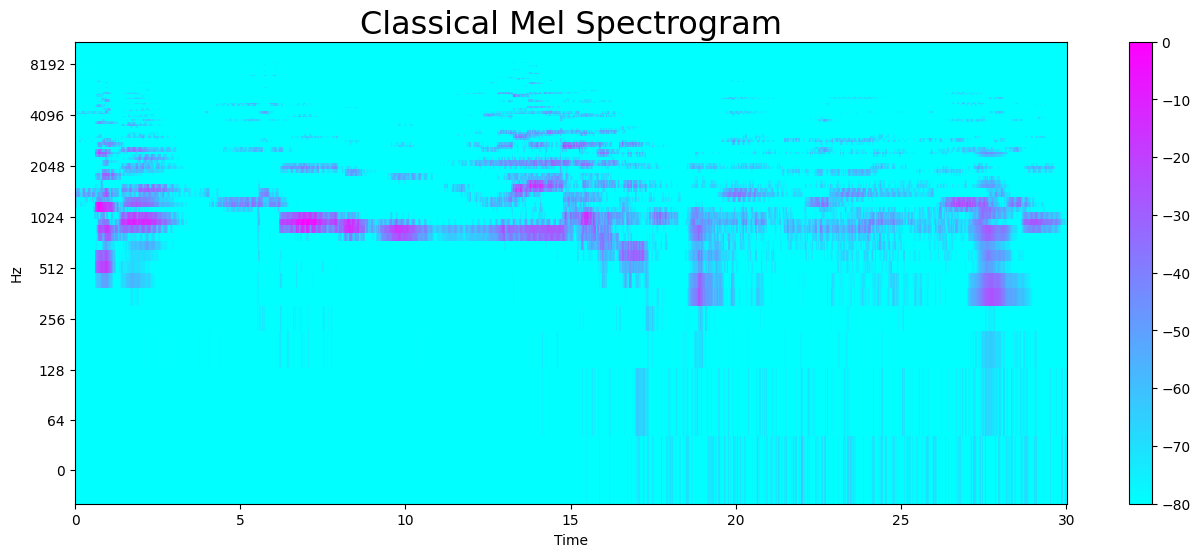

In [ ]:
y, sr = librosa.load(f'{general_path}/genres_original/classical/classical.00036.wav')
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool');
plt.colorbar();
plt.title("Classical Mel Spectrogram", fontsize = 23);

## Audio Features

### Zero Crossing Rate

* the rate at which the signal changes from positive to negative or back.

In [ ]:
# Total zero_crossings in our 1 song
zero_crossings = librosa.zero_crossings(audio_file, pad=False)
print(sum(zero_crossings))

39232


### Harmonics and Perceptrual

* Harmonics are characteristichs that human years can't distinguish (represents the sound color)
* Perceptrual understanding shock wave represents the sound rhythm and emotion

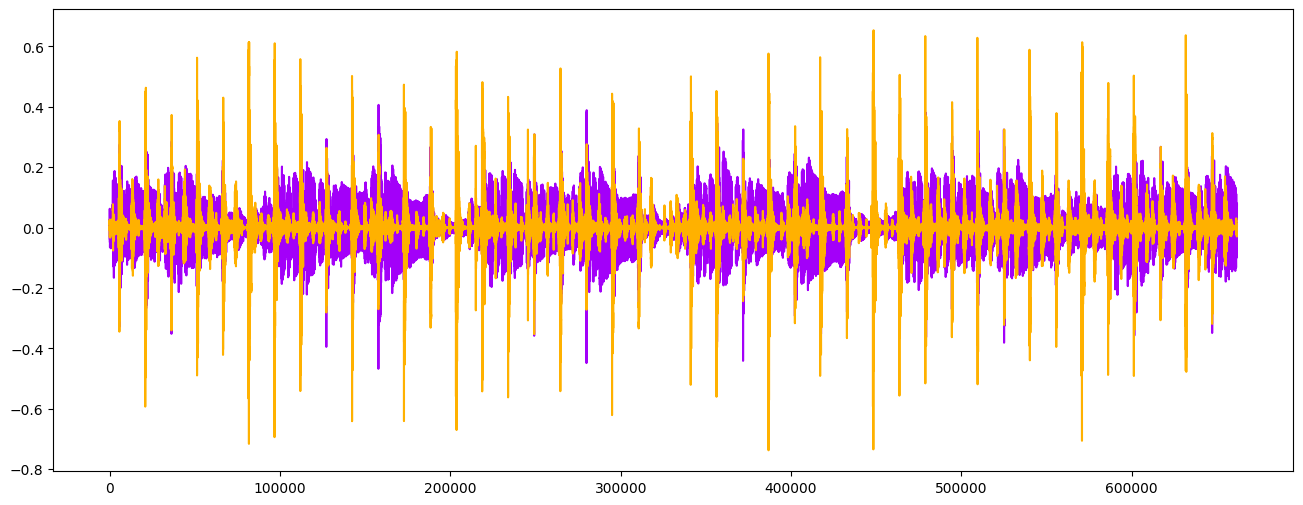

In [ ]:
y_harm, y_perc = librosa.effects.hpss(audio_file)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

### Tempo BMP (beats per minute)

Dynamic programming beat tracker.

In [ ]:
tempo, _ = librosa.beat.beat_track(y=y, sr = sr)
tempo

array([107.66601562])

### Spectral Centroid

* indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound.

In [ ]:
# Calculate the Spectral Centroids
spectral_centroids = librosa.feature.spectral_centroid(y=audio_file, sr=sr)[0]

# Shape is a vector
print('Centroids:', spectral_centroids, '\n')
print('Shape of Spectral Centroids:', spectral_centroids.shape, '\n')

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

print('frames:', frames, '\n')
print('t:', t)

Centroids: [1758.29476821 1946.74243805 2038.81133429 ...  766.50415702 1041.07728753
 1391.05146262] 

Shape of Spectral Centroids: (1293,) 

frames: range(0, 1293) 

t: [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.99537415e+01
 2.99769615e+01 3.00001814e+01]


In [ ]:
# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

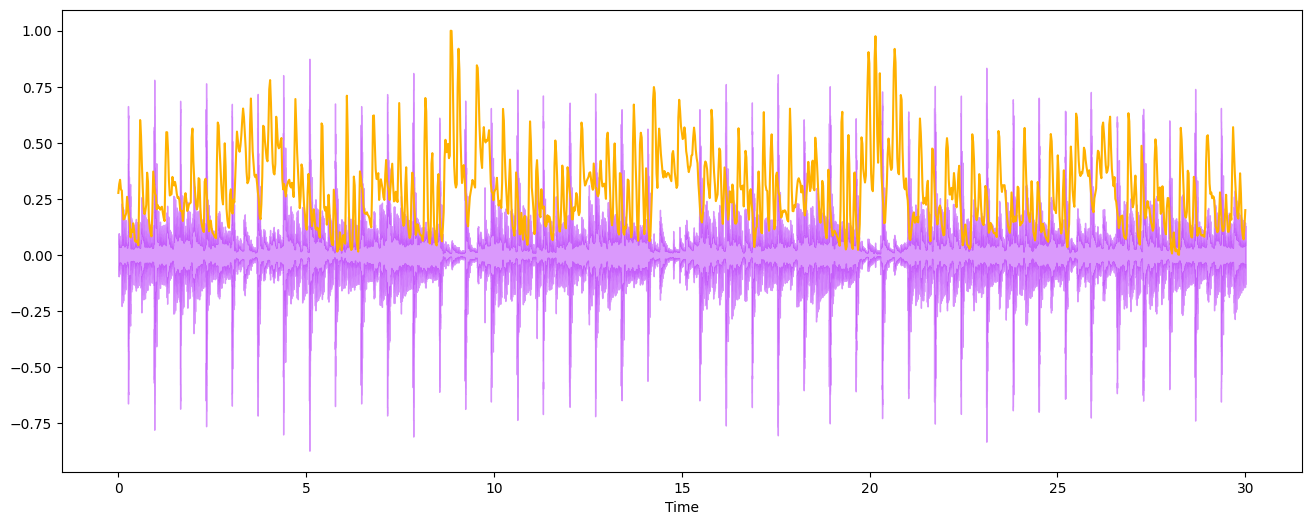

In [ ]:
#Plotting the Spectral Centroid along the waveform
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y=audio_file, sr=sr, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_centroids), color='#FFB100');

### Spectral Rolloff
* is a measure of the shape of the signal. It represents the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies

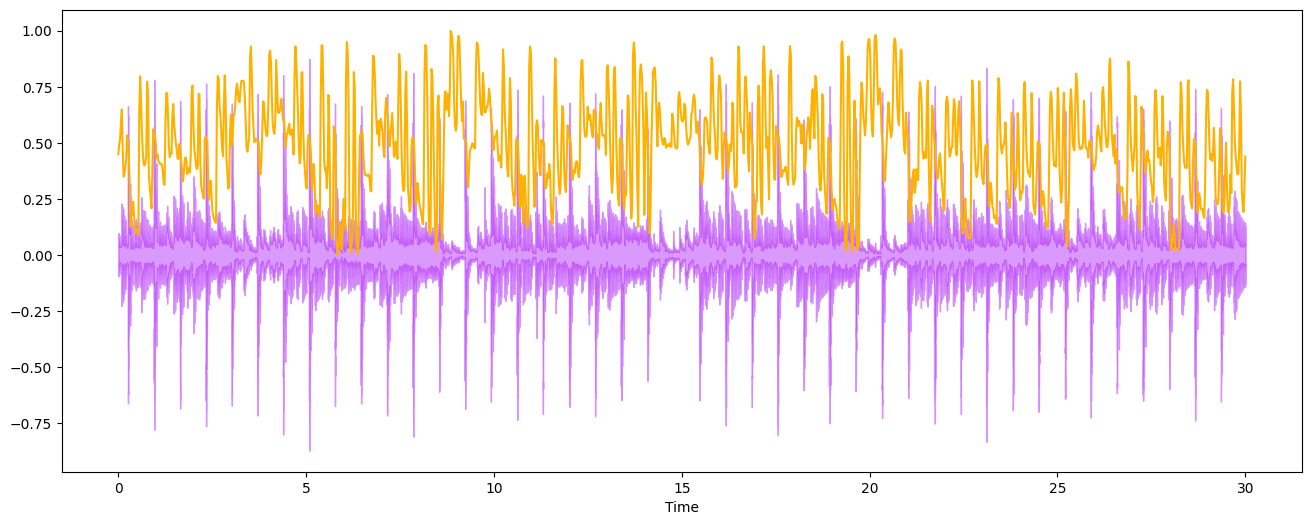

In [ ]:
# Spectral RollOff Vector
spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_file, sr=sr)[0]

# The plot
plt.figure(figsize = (16, 6))
librosa.display.waveshow(audio_file, sr=sr, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_rolloff), color='#FFB100');

### Mel-Frequency Cepstral Coefficients:

* The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.

mfccs shape: (20, 1293)


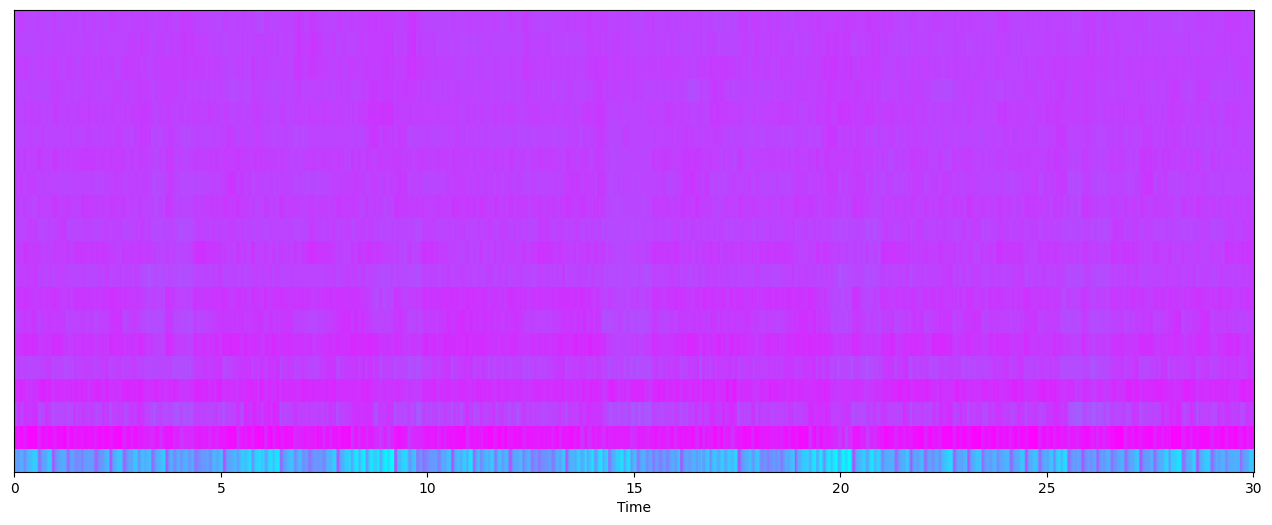

In [ ]:
mfccs = librosa.feature.mfcc(y=audio_file, sr=sr)
print('mfccs shape:', mfccs.shape)

#Displaying  the MFCCs:
plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

Mean: -1.032594e-09 

Var: 1.0000001


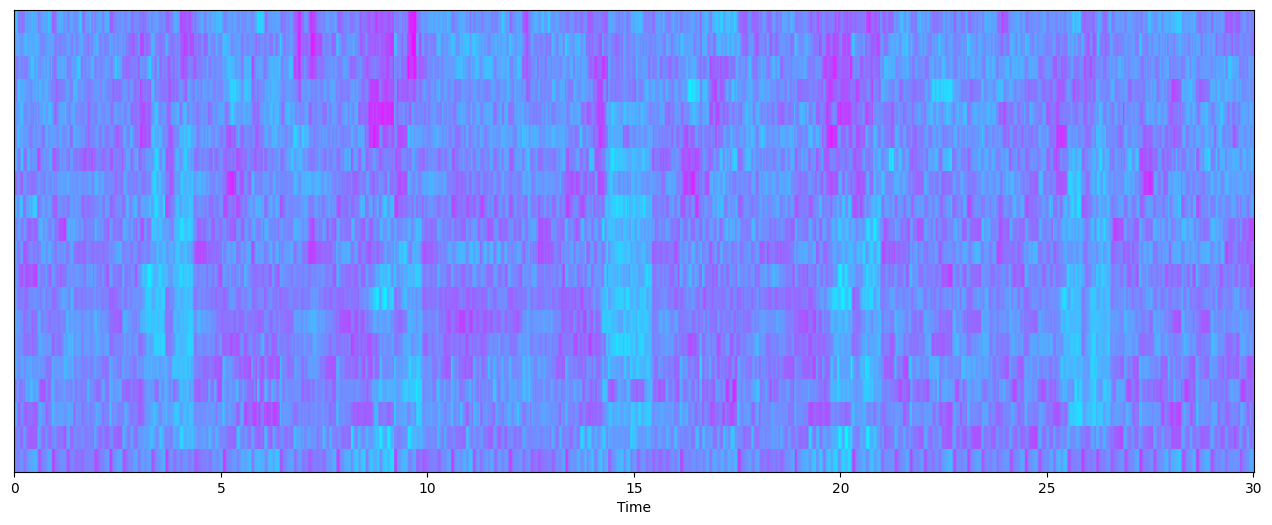

In [ ]:
# Perform Feature Scaling
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean:', mfccs.mean(), '\n')
print('Var:', mfccs.var())

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

### Chroma Frequencies

* Chroma features are an interesting and powerful representation for music audio in which the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave.

Chromogram shape: (12, 133)


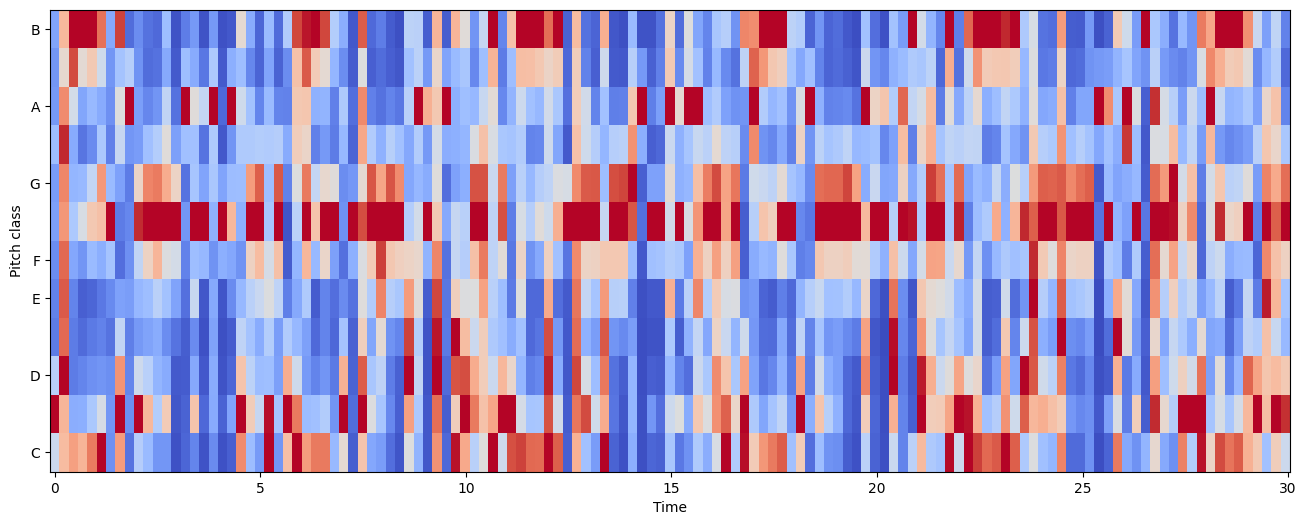

In [ ]:
# Increase or decrease hop_length to change how granular you want your data to be
hop_length = 5000

# Chromogram
chromagram = librosa.feature.chroma_stft(y=audio_file, sr=sr, hop_length=hop_length)
print('Chromogram shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm');

## EDA

EDA is going to be performed on the `features_30_sec.csv`. This file contains the mean and variance for each audio file fo the features analysed above.

So, the table has a final of 1000 rows (10 genrex x 100 audio files) and 60 features (dimensionalities).

In [ ]:
data = pd.read_csv(f'{general_path}/features_30_sec.csv')
data.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516           213843.755497  ...   55.356403   
2              1747.702312            76254.192257  ...   40.598766   
3              1596.412872           166441.494769  ...   44.427753   
4              1748.172116            88445.209036  ...   86.099236   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -1.690215   36.524071    -0.408979   41.597103    -2.303523   55.062923   
1    -0.731125   60.314529     0.295073   48.120598    -0.283518   51.106190   
2    -7.729093   47.639427    -1.816407   52.382141    -3.439720   46.639660   
3    -3.319597   50.206673     0.636965   37.319130    -0.619121   37.259739   
4    -5.454034   75.269707    -0.916874   53.613918    -4.404827   62.910812   

   mfcc20_mean  mfcc20_var  label  
0     1.221291   46.936035  blues  
1     0.531217   45.786282  blues  
2    -2.231258   30.573025  blues  
3    -3.407448   31.949339  blues  
4   -11.703234   55.195160  blues  

[5 rows x 60 columns]

### Correlation Heatmap for feature means

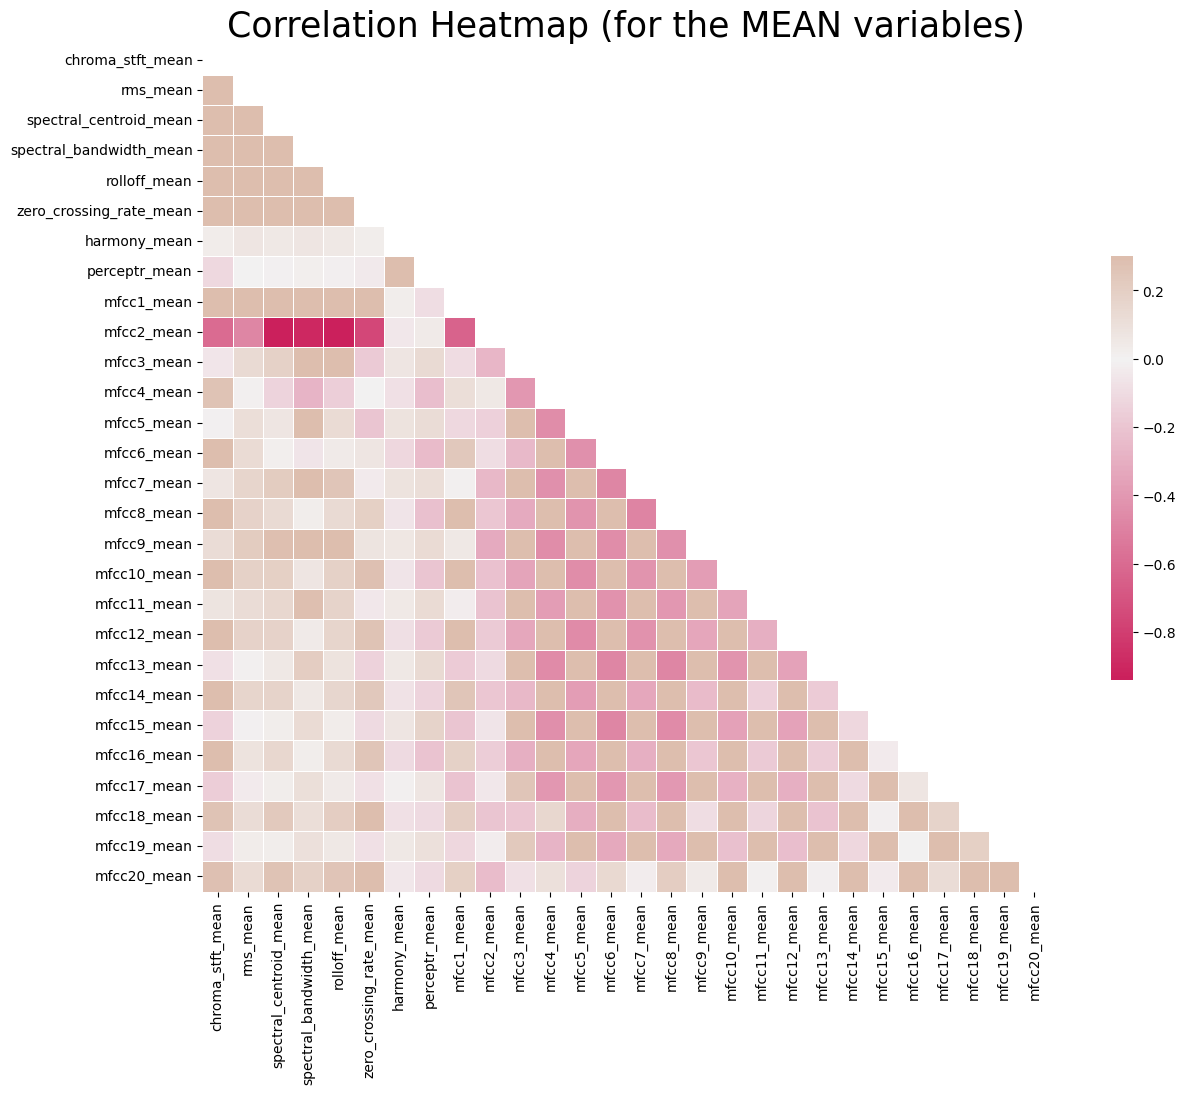

In [ ]:
# Computing the Correlation Matrix
spike_cols = [col for col in data.columns if 'mean' in col]
corr = data[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr Heatmap.jpg")

## Make MFCC features

In [11]:

dataset_path = r"/kaggle/input/gtzan-dataset-music-genre-classification/1/Data/genres_original"
json_path = r"data.json"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [12]:
import os
import librosa
import json
import math

SAMPLE_RATE = 22050
SAMPLES_PER_TRACK = SAMPLE_RATE * 30  # Assuming 30 seconds per track

def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048,
              hop_length=512, num_segments=5, selected_genres=None):
    # Data storage dictionary
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(SAMPLES_PER_TRACK / num_segments)  # ps = per segment
    expected_vects_ps = math.ceil(samples_ps / hop_length)

    # Loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # Ensuring not at root
        if dirpath is not dataset_path:
            # Save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]

            # Check if the genre is in the selected genres list (if provided)
            if selected_genres is None or semantic_label in selected_genres:
                data["mapping"].append(semantic_label)
                print(f"Processing: {semantic_label}")

                # Process files for specific genre
                for f in filenames:
                    if f == "jazz.00054.wav":
                        # As librosa only reads files <1Mb
                        continue
                    else:
                        # Load audio file
                        file_path = os.path.join(dirpath, f)
                        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                        for s in range(num_segments):
                            start_sample = samples_ps * s
                            finish_sample = start_sample + samples_ps

                            mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                                        sr=sr,
                                                        n_fft=n_fft,
                                                        n_mfcc=n_mfcc,
                                                        hop_length=hop_length)

                            mfcc = mfcc.T

                            # Store MFCC if it has the expected length
                            if len(mfcc) == expected_vects_ps:
                                data["mfcc"].append(mfcc.tolist())
                                data["labels"].append(i - 1)
                                print(f"{file_path}, segment: {s + 1}")

    # Save the data as a JSON file
    with open(json_path, "w") as f:
        json.dump(data, f, indent=4)

# Example usage:
# save_mfcc('dataset_path', 'output.json', selected_genres=['classical', 'rock'])


In [13]:
from IPython.display import clear_output

In [14]:
save_mfcc(dataset_path,json_path,num_segments=10)
clear_output()

In [25]:
filepath = r"/kaggle/input/gtzan-dataset-music-genre-classification/1/Data/genres_original/blues/blues.0000"

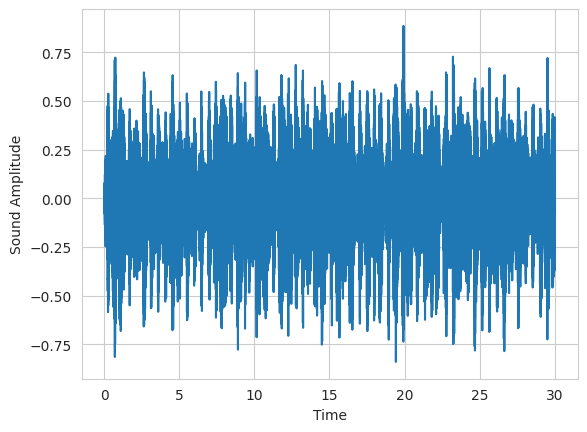

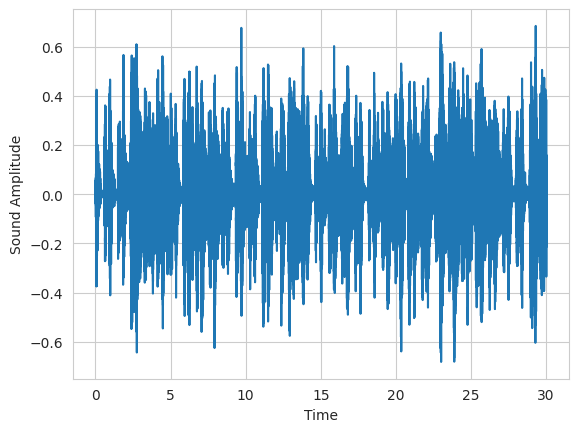

In [26]:
for i in range(2):
    audio, sfreq = librosa.load(filepath+str(i)+".wav")
    time = np.arange(0, len(audio))/sfreq
    plt.plot(time,audio)
    plt.xlabel("Time")
    plt.ylabel("Sound Amplitude")
    plt.show()

# ANN

## Data Preparation

- Treat missing values.
- Outlier Treatment
- Define dummy variables for categorical variables.

### Missing Value Treatment

In [66]:
# find all columns with any NA values
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


`No null values in the dataset`



`There are no categorical variable as such. Hence, Dummy variable creation is not needed.`

## Encode Genre Label

In [67]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [68]:
# update labels in df to index
df.label = [label_index[l] for l in df.label]

## Split Train, Dev & Test Sets

In [69]:
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [70]:
# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [71]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [72]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

10.01001001001001
10.010111223458038
10.009813542688912


## Scale the Features

In [73]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

## Model Building

In [74]:
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k
tf.random.set_seed(seed)

TF version:- 2.17.1


In [75]:
ACCURACY_THRESHOLD = 0.94

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs,
                     batch_size=batch_size, callbacks=[callback])

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [76]:
model_1 = k.models.Sequential([
    k.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(10, activation='softmax'),
])
print(model_1.summary())
model_1_history = trainModel(model=model_1, epochs=50, optimizer='adam')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 256)                 │          14,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,650 (221.29 KB)

 Trainable params: 56,650 (221.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3729 - loss: 1.7924 - val_accuracy: 0.6370 - val_loss: 1.0615
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6742 - loss: 0.9560 - val_accuracy: 0.7235 - val_loss: 0.8230
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7576 - loss: 0.7341 - val_accuracy: 0.7583 - val_loss: 0.7091
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7922 - loss: 0.6087 - val_accuracy: 0.7781 - val_loss: 0.6362
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8256 - loss: 0.5187 - val_accuracy: 0.7917 - val_loss: 0.5879
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8500 - loss: 0.4445 - val_accuracy: 0.8043 - val_loss: 0.5435
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8758 - loss: 0.3791 - val_accuracy: 0.8220 - val_loss: 0.5042
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9015 - loss: 0.3205 - val_accuracy: 0.8281 - val

Max. Validation Accuracy 0.8943377137184143


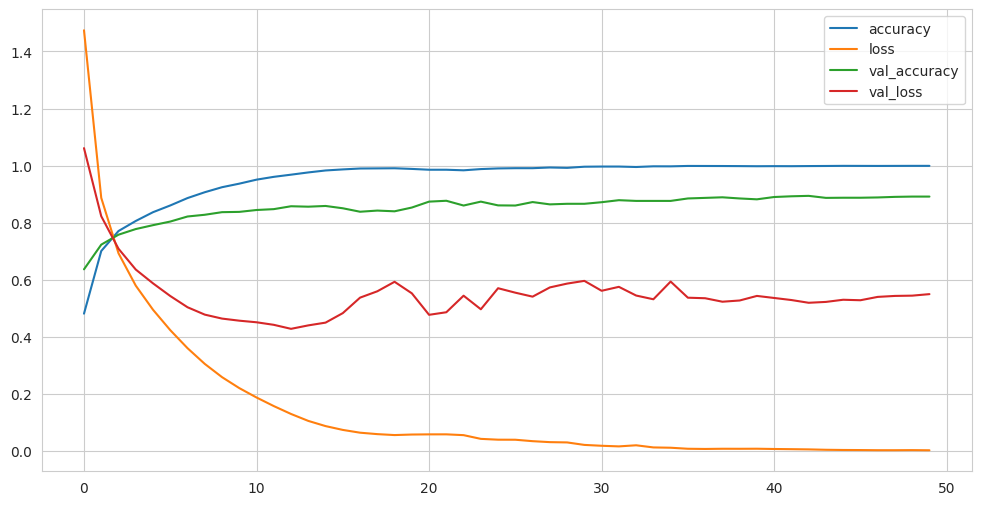

In [77]:
plotHistory(model_1_history)

In [ ]:
model_2 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),

    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_2.summary())
model_2_history = trainModel(model=model_2, epochs=50, optimizer='adam')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 512)                 │          29,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,826 (792.29 KB)

 Trainable params: 202,826 (792.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.3111 - loss: 1.9124 - val_accuracy: 0.6057 - val_loss: 1.1093
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5844 - loss: 1.2205 - val_accuracy: 0.7012 - val_loss: 0.8626
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6770 - loss: 0.9470 - val_accuracy: 0.7472 - val_loss: 0.7443
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7265 - loss: 0.8066 - val_accuracy: 0.7770 - val_loss: 0.6614
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7679 - loss: 0.7170 - val_accuracy: 0.7973 - val_loss: 0.5917
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7839 - loss: 0.6518 - val_accuracy: 0.8140 - val_loss: 0.5727
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8148 - loss: 0.5658 - val_accuracy: 0.8301 - val_loss: 0.5044
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8224 - loss: 0.5220 - val_accuracy: 0.842

Max. Validation Accuracy 0.9211324453353882


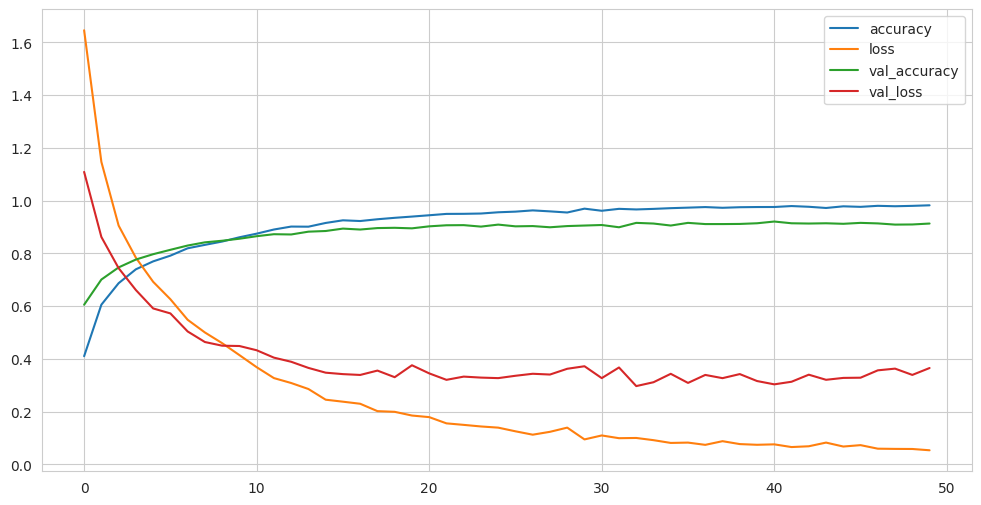

In [ ]:
plotHistory(model_2_history)

In [ ]:
model_3 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),

    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_3.summary())
model_3_history = trainModel(model=model_3, epochs=50, optimizer='sgd')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 512)                 │          29,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,826 (792.29 KB)

 Trainable params: 202,826 (792.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.1187 - loss: 2.3028 - val_accuracy: 0.2371 - val_loss: 2.1594
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2031 - loss: 2.1784 - val_accuracy: 0.3220 - val_loss: 2.0279
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2616 - loss: 2.0587 - val_accuracy: 0.3574 - val_loss: 1.8960
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3222 - loss: 1.9487 - val_accuracy: 0.3857 - val_loss: 1.7734
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3599 - loss: 1.8412 - val_accuracy: 0.4237 - val_loss: 1.6638
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3883 - loss: 1.7327 - val_accuracy: 0.4414 - val_loss: 1.5730
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4074 - loss: 1.6826 - val_accuracy: 0.4722 - val_loss: 1.5014
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4113 - loss: 1.6186 - val_accuracy: 0.4914

Max. Validation Accuracy 0.7371081709861755


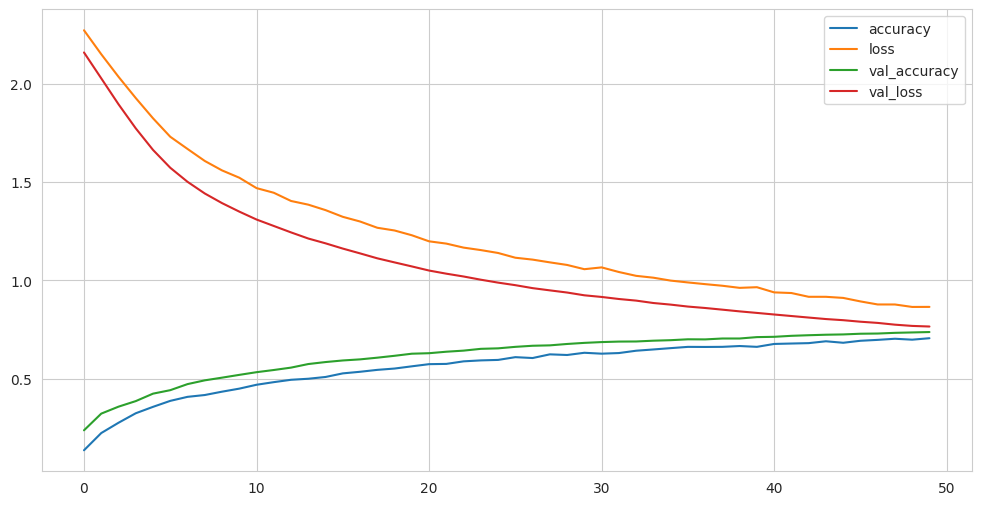

In [ ]:
plotHistory(model_3_history)

In [ ]:
model_4 = k.models.Sequential([
    k.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.3),

    k.layers.Dense(512, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(10, activation='softmax'),
])
print(model_4.summary())
model_4_history = trainModel(model=model_4, epochs=70, optimizer='rmsprop')

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                     │ (None, 1024)                │          59,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 757,322 (2.89 MB)

 Trainable params: 757,322 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.2898 - loss: 1.9215 - val_accuracy: 0.5779 - val_loss: 1.1857
Epoch 2/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5312 - loss: 1.3380 - val_accuracy: 0.6527 - val_loss: 1.0072
Epoch 3/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6201 - loss: 1.1332 - val_accuracy: 0.7037 - val_loss: 0.8749
Epoch 4/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6879 - loss: 0.9657 - val_accuracy: 0.7437 - val_loss: 0.7436
Epoch 5/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7238 - loss: 0.8381 - val_accuracy: 0.7674 - val_loss: 0.6970
Epoch 6/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7492 - loss: 0.7593 - val_accuracy: 0.7831 - val_loss: 0.6418
Epoch 7/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7907 - loss: 0.6397 - val_accuracy: 0.8094 - val_loss: 0.5960
Epoch 8/70
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8047 - loss: 0.6164 - val_accuracy: 0.821

Max. Validation Accuracy 0.9266936182975769


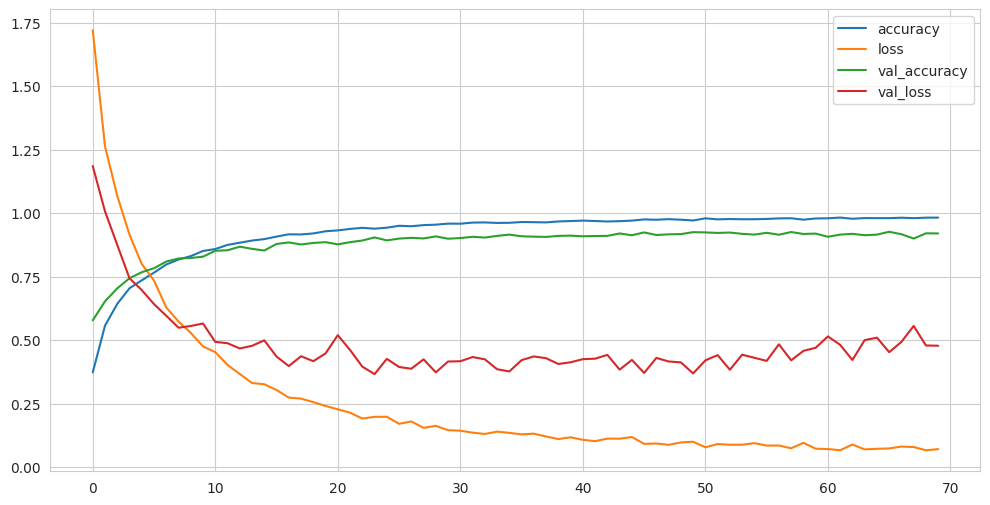

In [ ]:
plotHistory(model_4_history)

## Model Evaluation

In [ ]:
test_loss, test_acc  = model_4.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("\nThe Best test Accuracy is :",test_acc*100)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9188 - loss: 0.4084
The test Loss is : 0.44577696919441223

The Best test Accuracy is : 91.95289611816406


# CNN
Using keras layers of Conv2D, MaxPool2D, BatchNormalization.

CNN layers takes input primarily in 3D shape, so we again have to prepare the dataset in the form and for that, I have used np.newaxis function which adds a column/layer in the data

In [41]:
import json
import numpy as np
from keras.utils import to_categorical

# Genre labels mapping
GENRE_LABELS = {
    0: "disco",
    1: "metal",
    2: "reggae",
    3: "blues",
    4: "rock",
    5: "classical",
    6: "jazz",
    7: "hiphop",
    8: "country",
    9: "pop"
}
# usage for the json file that we have exploited from the .wav files
def load_data(dataset_path, selected_genres=None):
    with open(dataset_path, "r") as f:
        data = json.load(f)

    # Convert list to numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    if selected_genres is not None:
        # Convert selected_genres names to corresponding label indices
        selected_indices = [label for label, genre in GENRE_LABELS.items() if genre in selected_genres]
        print("SELECTED_INDICES", selected_indices)

        # Filter inputs and targets to only include the selected genres
        mask = np.isin(targets, selected_indices)
        inputs = inputs[mask]
        targets = targets[mask]

        # Create a label_map to reflect selected genre indices
        label_map = {old_label: idx for idx, old_label in enumerate(selected_indices)}
        print("LABEL_MAP", label_map)

        # Adjust the targets to reflect the new label indices starting from 0
        targets = np.array([label_map[target] for target in targets])
    else:
        # If no genres are selected, create a default label_map where each genre maps to itself
        label_map = {i: i for i in range(10)}

    # Convert labels to one-hot encoding with size 10
    targets = to_categorical(targets, num_classes=10)

    return inputs, targets, label_map


In [42]:
inputs, targets, label_map = load_data(dataset_path=r"./data.json", selected_genres=['classical', 'rock', 'jazz'])

SELECTED_INDICES [4, 5, 6]
LABEL_MAP {4: 0, 5: 1, 6: 2}


In [47]:
from sklearn.model_selection import train_test_split


def prepare_dataset(test_size, validation_size):
    X, y, _ = load_data(r"./data.json")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [48]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)

In [49]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

(130, 13, 1)


In [54]:
from tensorflow.keras.layers import *

In [55]:
model = k.models.Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 11, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 6, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 6, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 62, 4, 32)           │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 2, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 31, 2, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 1, 32)           │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 15, 1, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 1, 16)           │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 1, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 1, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,242 (129.85 KB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 288 (1.12 KB)

In [57]:
new_optimizer = k.optimizers.Adam()
model.compile(optimizer=new_optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 epochs = 40,
                 batch_size = 32)

Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - accuracy: 0.3008 - loss: 2.0623 - val_accuracy: 0.4399 - val_loss: 1.4757
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 142ms/step - accuracy: 0.4824 - loss: 1.4044 - val_accuracy: 0.5474 - val_loss: 1.2377
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 39s 130ms/step - accuracy: 0.5607 - loss: 1.2165 - val_accuracy: 0.5821 - val_loss: 1.1420
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 39s 122ms/step - accuracy: 0.6052 - loss: 1.0960 - val_accuracy: 0.5968 - val_loss: 1.0974
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 145ms/step - accuracy: 0.6444 - loss: 1.0105 - val_accuracy: 0.5988 - val_loss: 1.0954
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.6752 - loss: 0.9413 - val_accuracy: 0.5968 - val_loss: 1.1263
Epoch 7/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 136ms/step - accuracy: 0.6929 - loss: 0.8677 - val_accuracy: 0.6415 - val_loss: 1.0037
Epoch 8/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.7187 - loss: 0

<Figure size 2000x1500 with 0 Axes>

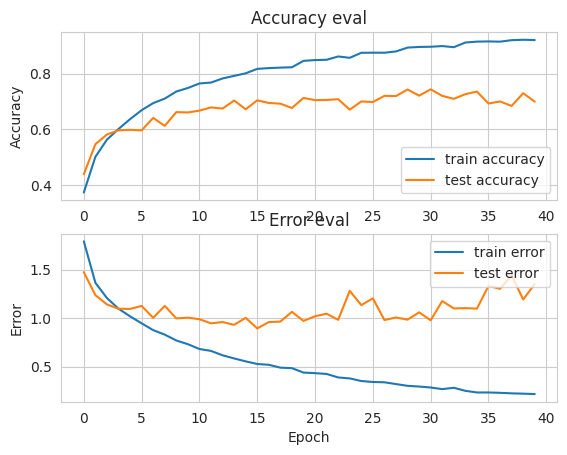

In [60]:
plot_history(hist)

In [ ]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7647 - loss: 0.8331
Test accuracy: 0.7693231701850891


In [61]:
def predict_(model, X, y):
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")

In [62]:
X_test.shape

(2497, 130, 13, 1)

In [63]:
predict_(model, X_test, y_test)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Expected index: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]], Predicted index: [3 4 5 ... 1 1 7]


In [81]:
type(predictions)

NoneType

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Assuming 'model' is your trained model
predictions = predict_(model, X_test,y_test)
predicted_labels = predictions.argmax(axis=1)
true_labels = targets.argmax(axis=1)


# Step 2: Compute metrics
conf_matrix = confusion_matrix(predicted_labels, predicted_labels)
precision = precision_score(predicted_labels, predicted_labels, average='weighted')
recall = recall_score(predicted_labels, predicted_labels, average='weighted')
f1 = f1_score(predicted_labels, predicted_labels, average='weighted')

# Reverse the label_map to get the genre names in order
inv_label_map = {v: k for k, v in label_map.items()}
genre_names = [GENRE_LABELS[inv_label_map[i]] for i in range(len(inv_label_map))]

# Plot the confusion matrix with genre names
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=genre_names[::-1],
            yticklabels=genre_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Display metrics
plt.figtext(0.2, -0.1, f'Precision: {precision:.4f}', fontsize=12)
plt.figtext(0.5, -0.1, f'Recall: {recall:.4f}', fontsize=12)
plt.figtext(0.8, -0.1, f'F1 Score: {f1:.4f}', fontsize=12)

plt.show()


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None